In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mplsoccer
import seaborn as sns
import os

### Get the data from Understat

I will scrape the first three Manchester United games from Understat

Corressponding match ids: 

MUN (1) vs Wolves (0) (22284)

Tottenham (2) vs MUN (0) (22290)

MUN (3) vs Nottingham Forest (2) (22300)

In [2]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
from tqdm import tqdm

base_url = 'https://understat.com/match/'

def scrape_data(match_id):
    match = str(match_id)
    url = base_url+match

    #Use requests to get the webpage and BeautifulSoup to parse the page
    res = requests.get(url)
    soup = BeautifulSoup(res.content, features = "lxml")
    scripts = soup.find_all('script')
    strings = scripts[1].string

    # strip unnecessary symbols and get only JSON data 
    ind_start = strings.index("('")+2 
    ind_end = strings.index("')") 
    json_data = strings[ind_start:ind_end] 
    json_data = json_data.encode('utf8').decode('unicode_escape')

    #convert string to json format
    data = json.loads(json_data)

    X = []
    Y = []
    minute = []
    result = []
    player = []
    situation = []
    player_assisted = []
    last_action = []
    team = []
    xG = []
    opp_team = []

    data_home = data['h']
    data_away = data['a']
    #len(data_home), len(data_away)

    for shot_data in data_home:
        X.append(shot_data['X'])
        Y.append(shot_data['Y'])
        minute.append(shot_data['minute'])
        result.append(shot_data['result'])
        player.append(shot_data['player'])
        situation.append(shot_data['situation'])
        player_assisted.append(shot_data['player_assisted'])
        last_action.append(shot_data['lastAction'])
        team.append(shot_data['h_team'])
        opp_team.append(shot_data['a_team'])
        xG.append(shot_data['xG'])


    for shot_data in data_away:
        X.append(shot_data['X'])
        Y.append(shot_data['Y'])
        minute.append(shot_data['minute'])
        result.append(shot_data['result'])
        player.append(shot_data['player'])
        situation.append(shot_data['situation'])
        player_assisted.append(shot_data['player_assisted'])
        last_action.append(shot_data['lastAction'])
        team.append(shot_data['a_team'])
        opp_team.append(shot_data['h_team'])
        xG.append(shot_data['xG'])

    col_names = ["minute", "X", "Y", "Team", "xG","Result","Player","Situation","Player_assisted","lastAction","Opp"]
    data_df = pd.DataFrame([minute, X, Y, team, xG, result, player, situation, player_assisted, last_action, opp_team], index = col_names).T
    data_df.sort_values(by = "minute", inplace = True)

    data_df.to_csv("shot_data_{}.csv".format(match), index = False)



In [3]:
matches = ['22284', '22290', '22300']
for match in tqdm(matches):
    scrape_data(match)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:01<00:00,  1.63it/s]


#### Analyse shots distribution

In [5]:
shot_data1 = pd.read_csv('shot_data_22284.csv')
shot_data1.insert(0, "GW", 1)
shot_data1.head()

,GW,minute,X,Y,Team,xG,Result,Player,Situation,Player_assisted,lastAction,Opp
0,1,10,0.893,0.320,Manchester United,0.059325,SavedShot,Marcus Rashford,OpenPlay,Antony,Pass,Wolverhampton Wanderers
1,1,12,0.794,0.655,Manchester United,0.019553,BlockedShot,Alejandro Garnacho,FromCorner,NaN,None,Wolverhampton Wanderers
2,1,17,0.888,0.633,Wolverhampton Wanderers,0.017459,BlockedShot,João Gomes,SetPiece,Pedro Neto,Cross,Manchester United
3,1,2,0.737,0.352,Wolverhampton Wanderers,0.016892,BlockedShot,Matheus Cunha,OpenPlay,Nélson Semedo,Pass,Manchester United
4,1,25,0.859,0.649,Wolverhampton Wanderers,0.063966,BlockedShot,Pablo Sarabia,OpenPlay,Matheus Cunha,CornerAwarded,Manchester United


In [9]:
shots_data_mun = pd.DataFrame()
for i, match_id in enumerate(matches):
    shot_data_gw = pd.read_csv('shot_data_{}.csv'.format(match_id))
    shot_data_gw.insert(0, "GW", i+1)
    print (shot_data_gw.shape)
    shots_data_mun = pd.concat([shots_data_mun, shot_data_gw], axis = 0)
    
print (shots_data_mun.shape)
    

(38, 12)
(40, 12)
(27, 12)
(105, 12)


In [10]:
shots_data_mun.head()

,GW,minute,X,Y,Team,xG,Result,Player,Situation,Player_assisted,lastAction,Opp
0,1,10,0.893,0.320,Manchester United,0.059325,SavedShot,Marcus Rashford,OpenPlay,Antony,Pass,Wolverhampton Wanderers
1,1,12,0.794,0.655,Manchester United,0.019553,BlockedShot,Alejandro Garnacho,FromCorner,NaN,None,Wolverhampton Wanderers
2,1,17,0.888,0.633,Wolverhampton Wanderers,0.017459,BlockedShot,João Gomes,SetPiece,Pedro Neto,Cross,Manchester United
3,1,2,0.737,0.352,Wolverhampton Wanderers,0.016892,BlockedShot,Matheus Cunha,OpenPlay,Nélson Semedo,Pass,Manchester United
4,1,25,0.859,0.649,Wolverhampton Wanderers,0.063966,BlockedShot,Pablo Sarabia,OpenPlay,Matheus Cunha,CornerAwarded,Manchester United


In [12]:
shots_data_mun['GW'].nunique()

3

In [19]:
def get_cmap(result):
    cmap ={'MissedShots':'red',
            'BlockedShot':'black',
            'SavedShot':'yellow',
            'Goal':'Blue',
            'ShotOnPost':'Orange'}
    return cmap[result]

def create_shot_map(data, team, heatmap = False, savefig = True, chance_creation = True):
    if chance_creation==True:
        search_key = 'Team'
    else:
        search_key = 'Opp'
        
    df2 = data[data[search_key]==team]
    pitch = mplsoccer.Pitch(pitch_color = 'grass', half = True, line_alpha=0.7)
    X_max = 120
    Y_max = 80

    #Dropping own goals
    df2.drop(df2[df2['Result']=="OwnGoal"].index.values, inplace = True)
    result_types = list(df2['Result'].unique())

    n_gws = df2['GW'].nunique()
    fig, axs = plt.subplots(1, n_gws, figsize=(30, 15))
    #pitch = mplsoccer.Pitch(pitch_color = 'grass', goal_type='box', goal_alpha=1)  # you can also adjust the transparency (alpha)
    pitch.draw(axs[0])
    axs[0].invert_yaxis()

    pitch.draw(axs[1])
    axs[1].invert_yaxis()

    pitch.draw(axs[2])
    axs[2].invert_yaxis()

    gws = np.arange(1, n_gws+1)
    
    for i, gw in enumerate(gws):
        df_gw = df2[df2["GW"]==gw]
        for result_type in result_types:
            d_t = df_gw[df_gw['Result']==result_type]
            c = get_cmap(result_type)
            axs[i].scatter(d_t['X']*X_max, d_t['Y']*Y_max, s = 1000*d_t['xG'], color = c, label = "{}".format(result_type))

        for idx, row in df_gw.iterrows():
            axs[i].text(row['X']*X_max, (row['Y']*Y_max), str(row['Player'].split()[-1]) + "\n" + str(round(row['xG'], 2)), fontsize = 10, color = 'white')

        if heatmap:
            kde = sns.kdeplot(
                df_gw['X']*X_max,
                df_gw['Y']*Y_max,
                shade = True,
                shade_lowest=False,
                alpha=.2,
                n_levels=5,
                cmap = 'magma', 
                ax = axs[i]
            )
        
        shot_team = df_gw['Team'].values[0]
        opp = df_gw["Opp"].values[0]

        axs[i].legend(loc = "upper right")
        axs[i].set_title("{}'s shots vs {}".format(shot_team, opp))

        
    if savefig:
        if chance_creation:
            shot_type = 'created'
        else:
            shot_type = 'conceded'
        plt.savefig("Shots_{}_{}.png".format(team, shot_type))
    plt.show()

c:\users\dbang\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\users\dbang\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\dbang\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

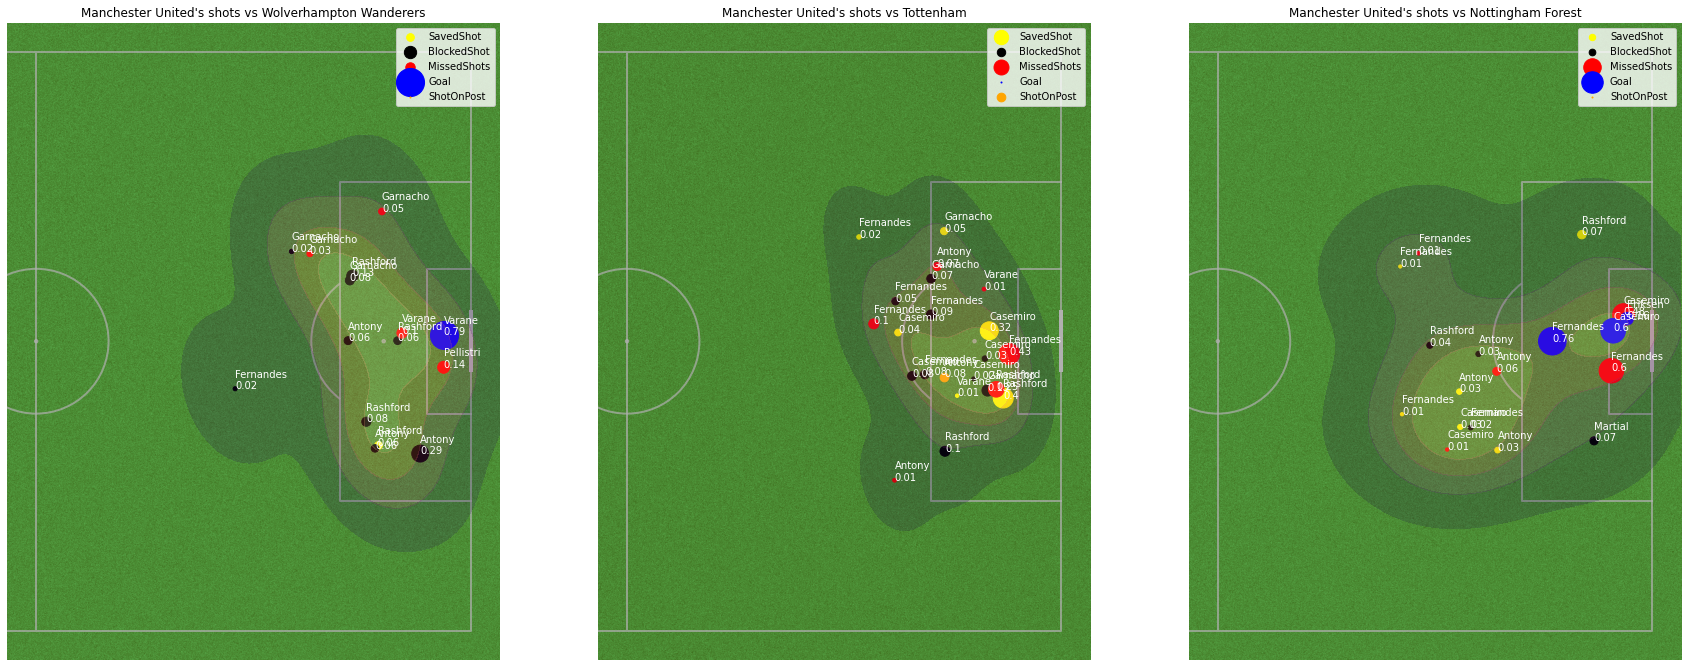

In [20]:
create_shot_map(shots_data_mun, team = "Manchester United", heatmap = True, savefig = True, chance_creation = True)

c:\users\dbang\appdata\local\programs\python\python37\lib\site-packages\pandas\core\frame.py:4908: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
c:\users\dbang\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
c:\users\dbang\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result i

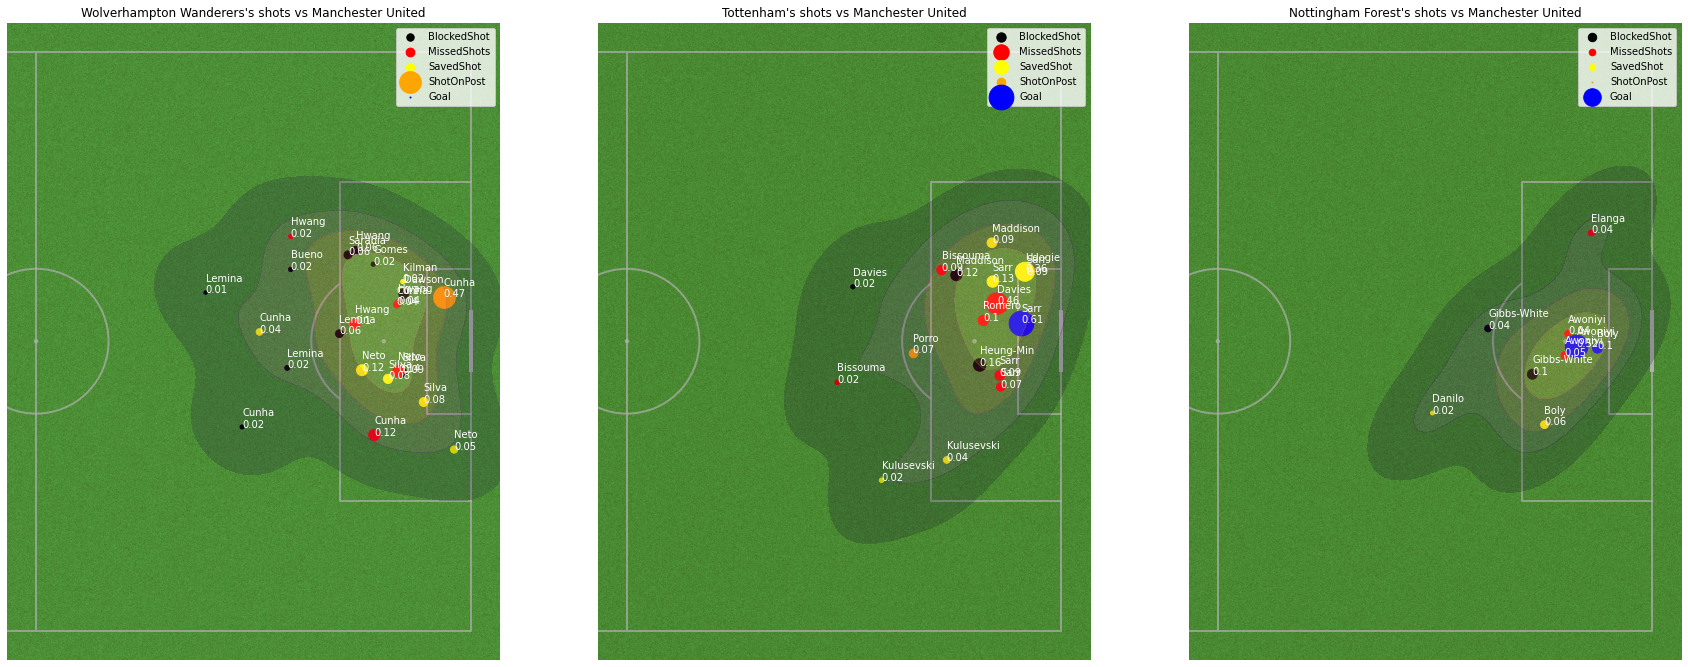

In [22]:
create_shot_map(shots_data_mun, team = "Manchester United", heatmap = True, savefig = True, chance_creation = False)

### Analyse game results

In [24]:
def sample_poisson_binom(ps):
    n = len(ps)
    X = 0
    for i in range(n):
        p_i = ps[i]
        r = np.random.random()
        if r<=p_i:
            X=X+1
    return X

def rpoisson_binom(ps, n_sims = 1000):
    simulated = [sample_poisson_binom(ps) for i in range(n_sims)]
    return simulated

def get_counts(arr, type = "probability", norm = True):
    vals = {}
    for val in arr:
        vals[val] = vals.get(val,0)+1
    if norm==True:
        for val in vals:
            vals[val] = vals[val]/len(arr)
    return vals

def get_most_likely(counts_hteam, counts_ateam):
    max_hteam_p = 0
    max_hteam_g = 0

    max_ateam_p = 0
    max_ateam_g = 0

    for key in counts_hteam.keys():
        if counts_hteam[key]>max_hteam_p:
            max_hteam_p = counts_hteam[key]
            max_hteam_g = key

    for key in counts_ateam.keys():
        if counts_ateam[key]>max_ateam_p:
            max_ateam_p = counts_ateam[key]
            max_ateam_g = key

    return (max_hteam_g, max_ateam_g, (max_hteam_p*max_ateam_p))

def get_score_likelihood(g_hteam, g_ateam, counts_hteam, counts_ateam):
    return (counts_hteam.get(g_hteam,0)*counts_ateam.get(g_ateam,0))

In [27]:
shots_data_mun['Team'].value_counts()

Manchester United          56
Wolverhampton Wanderers    23
Tottenham                  17
Nottingham Forest           9
Name: Team, dtype: int64

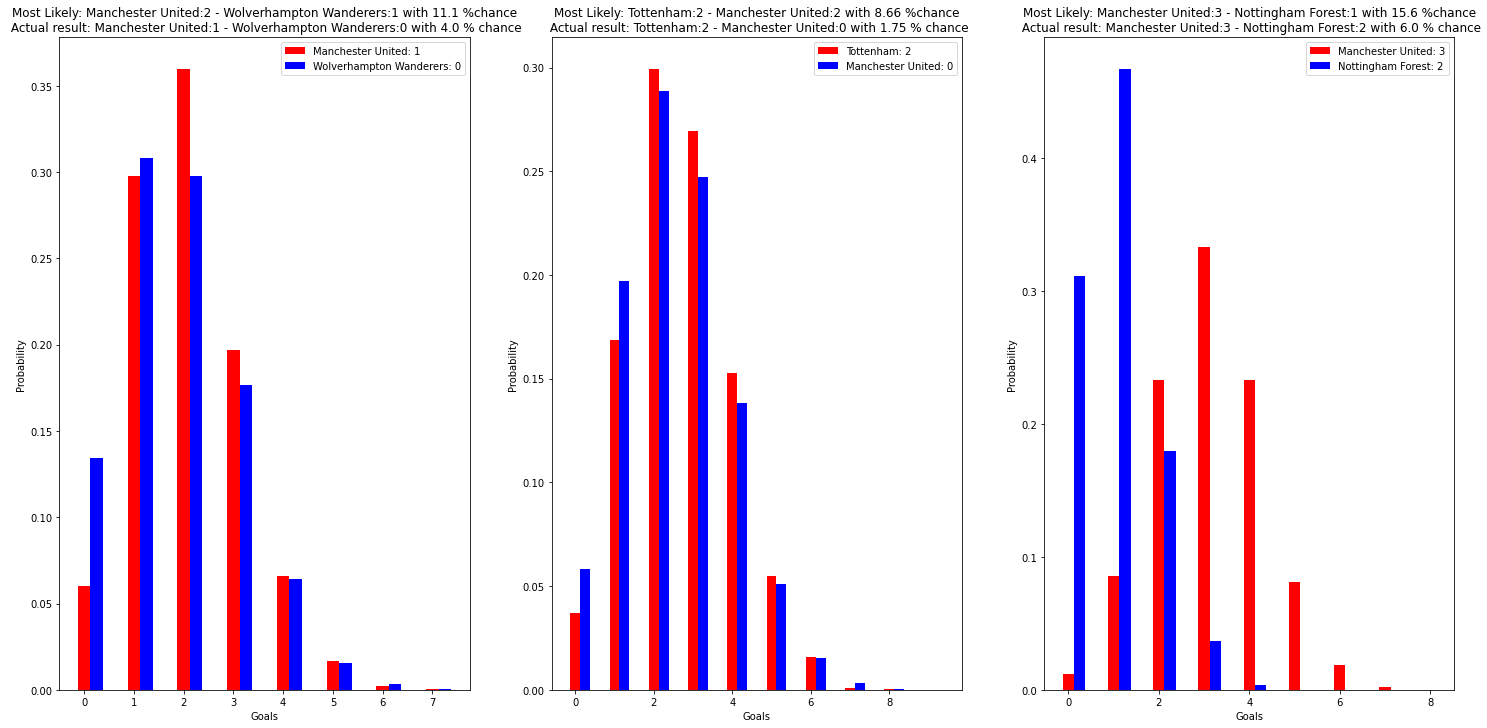

In [29]:

home_teams = ["Manchester United", "Tottenham", "Manchester United"]
away_teams = ["Wolverhampton Wanderers", "Manchester United", "Nottingham Forest"]

home_goals = [1, 2, 3]
away_goals = [0, 0, 2]

fig, axs = plt.subplots(1, 3, figsize = (25, 12))

for gw in range(3):
    shots_df = shots_data_mun[shots_data_mun['GW']==gw+1]
    h_team = home_teams[gw]
    a_team = away_teams[gw]
    h_goals = home_goals[gw]
    a_goals = away_goals[gw]
    
    xGs_hteam = shots_df[shots_df["Team"]==h_team]['xG'].values
    xGs_ateam = shots_df[shots_df["Team"]==a_team]['xG'].values
    
    simulate_Home_team = rpoisson_binom(xGs_hteam, n_sims = 10000)
    simulate_Away_team = rpoisson_binom(xGs_ateam, n_sims = 10000)
    
    counts_hteam = get_counts(simulate_Home_team)
    counts_ateam = get_counts(simulate_Away_team)
    
    axs[gw].bar(np.array(list(counts_hteam.keys())), counts_hteam.values(), width = 0.25, color = "red", label ="{}: {}".format(h_team, h_goals))
    axs[gw].bar(np.array(list(counts_ateam.keys()))+0.25, counts_ateam.values(), width = 0.25, color = "blue", label = "{}: {}".format(a_team, a_goals))
    axs[gw].set_xlabel("Goals")
    axs[gw].set_ylabel("Probability")

    ml_hg, ml_ag, ml_p = get_most_likely(counts_hteam, counts_ateam)
    score_likelihood = get_score_likelihood(h_goals, a_goals, counts_hteam, counts_ateam)
    axs[gw].set_title("Most Likely: {}:{} - {}:{} with {} %chance\n Actual result: {}:{} - {}:{} with {} % chance".format(h_team, ml_hg, a_team, ml_ag, round(ml_p*100,2), h_team, h_goals, a_team, a_goals, round(score_likelihood*100,2)))
    axs[gw].legend()

plt.savefig('Games_analysis.png')
plt.show()
    